RQ2: How are interactions and collaborative relationships between innovation actors emphasized in national quantum strategies?

Core Objective: To move beyond frequency analysis and map the structural topology of the innovation ecosystem, identifying how actors are linked within the strategic narrative.

0. Data Initialization

In [ ]:
import pandas as pd
output_df = pd.read_csv("output.csv")
entities_df = pd.read_csv("entities_to_edit.csv")

Network Topology Construction

Co-Occurence with Keywords

Quadruple  Helix Network Graph

In [38]:
import pandas as pd
import itertools
import networkx as nx
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. SETUP
TARGETS = ["Civil Society", "Government", "Industry", "Academia"]
df_ent_all = pd.read_csv("entities_to_edit.csv").fillna("")

# Data Cleaning
if 'Country' in df_ent_all.columns:
    countries = df_ent_all['Country'].unique()
    countries = [c for c in countries if str(c).strip() != ""]
    if len(countries) > 4:
        countries = countries[:4]
else:
    countries = []

df_ent_all['qh_category'] = df_ent_all['qh_category'].astype(str).str.strip()
df_ent_all = df_ent_all[df_ent_all['qh_category'].isin(TARGETS)]

# --- PREPARE TITLES ---
subplot_titles = []
for c in countries:
    country_data = df_ent_all[df_ent_all['Country'] == c]
    year_label = ""
    # Try finding Year or Date
    if 'Year' in country_data.columns:
        try: y = country_data['Year'].mode()[0]; year_label = f"({int(y)})"
        except: pass
    elif 'Date' in country_data.columns:
         try: y = pd.to_datetime(country_data['Date']).dt.year.mode()[0]; year_label = f"({int(y)})"
         except: pass
    subplot_titles.append(f"{c} {year_label}")

# Initialize Figure
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=subplot_titles,
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "scatter"}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.08
)

def get_clean_traces(df_country):
    G = nx.Graph()
    G.add_nodes_from(TARGETS)
    
    # Build Edges
    grouped = df_country.groupby(['Doc_ID', 'Paragraph_ID'])
    for _, group in grouped:
        found = group['qh_category'].tolist()
        if len(found) >= 2:
            for c1, c2 in itertools.combinations(sorted(found), 2):
                if c1 != c2:
                    if G.has_edge(c1, c2): G[c1][c2]['weight'] += 1
                    else: G.add_edge(c1, c2, weight=1)

    edges = G.edges(data=True)
    weights = [d['weight'] for u, v, d in edges]
    max_edge_w = max(weights) if weights else 1
    pos = nx.circular_layout(G, scale=1)
    
    traces = []
    
    # Edges
    for u, v, d in edges:
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        w = d['weight']
        width_px = 1 + (w / max_edge_w) * 8
        traces.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            line=dict(width=width_px, color='#888888'), 
            hoverinfo='text', text=f"Mentions: {w}",
            mode='lines', showlegend=False
        ))

    # Nodes
    node_x, node_y, node_text = [], [], []
    degrees = dict(G.degree(weight='weight'))
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x); node_y.append(y)
        node_text.append(f"<b>{node}</b><br>Volume: {degrees.get(node, 0)}")

    traces.append(go.Scatter(
        x=node_x, y=node_y, mode='markers+text',
        text=list(G.nodes()), textposition="bottom center",
        textfont=dict(size=12, color="black", family="Arial"),
        hovertext=node_text, hoverinfo='text',
        marker=dict(color='#2c3e50', size=35, line=dict(width=1, color='black')),
        showlegend=False
    ))
    return traces

# LOOP
for i, country in enumerate(countries):
    row = (i // 2) + 1; col = (i % 2) + 1
    df_subset = df_ent_all[df_ent_all['Country'] == country]
    for trace in get_clean_traces(df_subset):
        fig.add_trace(trace, row=row, col=col)

# FINAL LAYOUT
fig.update_layout(
    template="plotly_white",
    title=dict(text="<b>Comparative Quadruple Helix Ecosystems</b>", x=0.5, y=0.98, font=dict(size=22)),
    font=dict(family="Arial, sans-serif", color="black"),
    height=900, width=1000, showlegend=False,
    margin=dict(b=100) # Reduced margin since text is smaller
)

# Minimal Footer
fig.add_annotation(
    text="<b>Visualizing actor co-occurrence in national strategy documents.</b>",
    xref="paper", yref="paper",
    x=0.5, y=-0.1,
    showarrow=False,
    font=dict(size=12, color="#555555"),
    align="center",
    bordercolor="#333", borderwidth=1, borderpad=10, bgcolor="#f9f9f9"
)

fig.update_xaxes(visible=False); fig.update_yaxes(visible=False)
fig.show()

Co-Occurence Heatmap

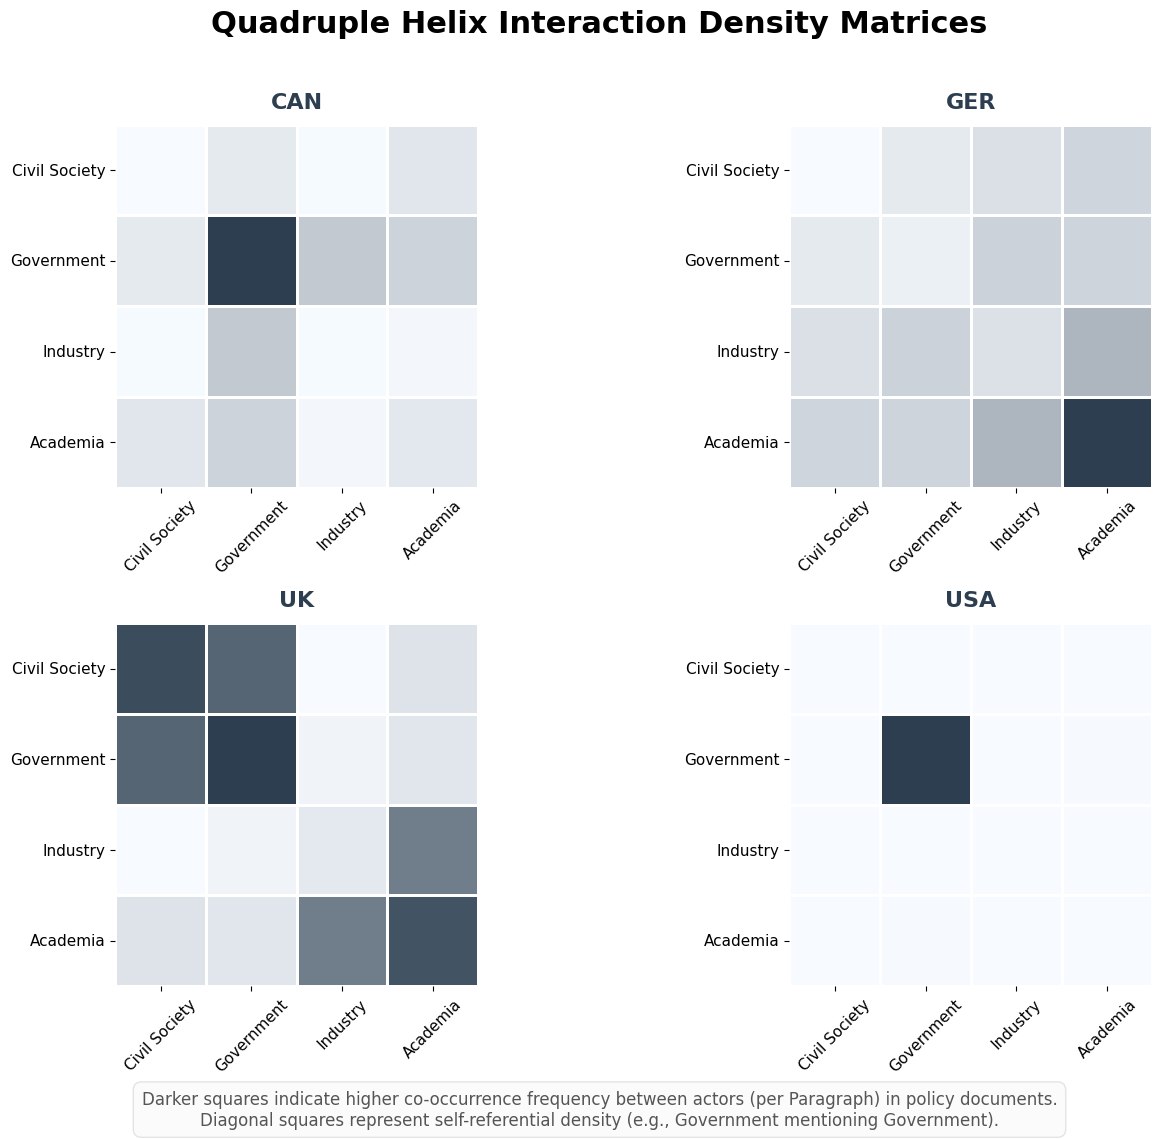

In [39]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# 1. CONFIGURATION
TARGETS = ["Civil Society", "Government", "Industry", "Academia"]
entities_csv = "entities_to_edit.csv"

# 2. LOAD & PREPARE DATA
df_ent = pd.read_csv(entities_csv).fillna("")

# Filter for the 4 Helix Categories
df_ent['qh_category'] = df_ent['qh_category'].astype(str).str.strip()
df_ent = df_ent[df_ent['qh_category'].isin(TARGETS)]

# Get list of countries
if 'Country' in df_ent.columns:
    countries = df_ent['Country'].unique()
    countries = [c for c in countries if str(c).strip() != ""]
    # Limit to top 4 for the 2x2 grid
    if len(countries) > 4:
        countries = countries[:4]
else:
    countries = []

# --- CUSTOM COLORMAP ---
# Gradient from White -> Dark Slate Blue (#2c3e50)
colors = ["#f7fbff", "#2c3e50"] 
custom_cmap = mcolors.LinearSegmentedColormap.from_list("CustomSlate", colors)

# 3. SETUP GRID
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# 4. PROCESS EACH COUNTRY
for i, country in enumerate(countries):
    ax = axes[i]
    
    # Initialize 4x4 Zero Matrix
    matrix_df = pd.DataFrame(0, index=TARGETS, columns=TARGETS)

    # Filter data
    df_subset = df_ent[df_ent['Country'] == country]

    # Group by Paragraph
    grouped = df_subset.groupby(['Doc_ID', 'Paragraph_ID'])

    for _, group in grouped:
        categories = group['qh_category'].tolist()
        if len(categories) < 2:
            continue
        
        # Add weights for every pair found
        for c1, c2 in itertools.combinations(sorted(categories), 2):
            matrix_df.loc[c1, c2] += 1
            if c1 != c2:
                matrix_df.loc[c2, c1] += 1  # Symmetry

    # --- PLOT HEATMAP ---
    sns.heatmap(
        matrix_df, 
        ax=ax, 
        annot=False,          # No Numbers
        cbar=False,           # <--- REMOVED SCALE BAR
        cmap=custom_cmap,     # Matching Slate Blue color
        linewidths=1, 
        linecolor='white',
        square=True           # Forces squares to be perfect boxes
    )

    # Styling
    ax.set_title(f"{country}", fontsize=16, fontweight='bold', color='#2c3e50', pad=12)
    
    # Axis Labels
    ax.tick_params(axis='x', rotation=45, labelsize=11)
    ax.tick_params(axis='y', rotation=0, labelsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Titles
plt.suptitle("Quadruple Helix Interaction Density Matrices", fontsize=22, fontweight='bold', color='black', y=0.96)

# Footer Explanation
plt.figtext(
    0.5, 0.03, 
    "Darker squares indicate higher co-occurrence frequency between actors (per Paragraph) in policy documents.\n"
    "Diagonal squares represent self-referential density (e.g., Government mentioning Government).", 
    ha="center", fontsize=12, color="#555555",
    bbox=dict(facecolor='#f9f9f9', alpha=0.5, boxstyle='round,pad=0.5', edgecolor='#cccccc')
)

plt.tight_layout(rect=[0, 0.06, 1, 0.94]) 
plt.show()